# Connect to Local SQL Server Database
This section demonstrates how to connect to your local SQL Server database using Python.

In [1]:
import pandas as pd
from sqlalchemy import create_engine, inspect
import json
import ast
import matplotlib.pyplot as plt

In [2]:
# Safely parse the similarity_metrics column, handling both single and double quotes
def safe_json_loads(val):
    try:
        return json.loads(val)
    except json.JSONDecodeError:
        try:
            return ast.literal_eval(val)
        except Exception:
            return {}

## Retrieve Data

In [3]:
# Connection parameters
server = '10.0.0.2'
database = 'Thesis'
username = 'sa'
password = 'e1r2e3n4'

In [4]:
# Create SQLAlchemy engine for SQL Server using pymssql
engine = create_engine(f"mssql+pymssql://{username}:{password}@{server}:1433/{database}")

In [5]:
# Use SQLAlchemy's inspect to get all table names
inspector = inspect(engine)
table_names = inspector.get_table_names()
print('Tables found:\n', "\n".join(table_names), sep="")

Tables found:
squad_structured_train
squad_structured_validation
temp_train_metrics_update
temp_validation_metrics_update
train_answer_predictions
unique_squad_train_context
unique_squad_validation_context
validation_answer_predictions


In [6]:
# Retrieve data from all tables into separate DataFrames
dataframes = {}
for table in table_names:
    if "structured" in table:
        try:
            df = pd.read_sql(f'SELECT * FROM {table}', engine)
            dataframes[table] = df
            print(f"Loaded {table} into DataFrame with {len(df)} rows.")
        except Exception as e:
            print(f"Failed to load {table}: {e}")

Loaded squad_structured_train into DataFrame with 87599 rows.
Loaded squad_structured_validation into DataFrame with 10570 rows.
Loaded squad_structured_validation into DataFrame with 10570 rows.


## Train Set

In [7]:
df1 = dataframes["squad_structured_train"]

In [8]:
df1.columns

Index(['squad_id', 'title', 'context', 'structurized_context', 'question',
       'answer_text', 'answer_start_index', 'structurized_answer_start_index',
       'similarity_metrics'],
      dtype='object')

In [9]:
df1 = df1.drop(columns=["structurized_context", "question", "answer_text", "answer_start_index", "structurized_answer_start_index"])

In [10]:
df1.columns

Index(['squad_id', 'title', 'context', 'similarity_metrics'], dtype='object')

In [11]:
# Show DataFrame grouped by 'context' with unique rows
unique_df = df1.drop_duplicates(subset=['context'])
unique_df = unique_df.reset_index(drop=True)
unique_df

,squad_id,title,context,similarity_metrics
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/bi:'j?nseI/ b...,"{'colbert': [0.8973691463470459], 'sparse': [2..."
1,56be86cf3aeaaa14008c9076,Beyoncé,Following the disbandment of Destiny's Child i...,"{'colbert': [0.9272266030311584], 'sparse': [2..."
2,56be88473aeaaa14008c9080,Beyoncé,"A self-described ""modern-day feminist"", Beyonc...","{'colbert': [0.9256731271743774], 'sparse': [2..."
3,56be892d3aeaaa14008c908b,Beyoncé,"Beyoncé Giselle Knowles was born in Houston, T...","{'colbert': [0.9348885416984558], 'sparse': [2..."
4,56be8a583aeaaa14008c9094,Beyoncé,Beyoncé attended St. Mary's Elementary School ...,"{'colbert': [0.925513505935669], 'sparse': [1...."
...,...,...,...,...
18886,5735d0026c16ec1900b92815,Kathmandu,"Institute of Medicine, the central college of ...","{'colbert': [0.87876957654953], 'sparse': [1.0..."
18887,5735d07d012e2f140011a087,Kathmandu,Football and Cricket are the most popular spor...,"{'colbert': [0.9161341190338135], 'sparse': [1..."
18888,5735d0f46c16ec1900b92823,Kathmandu,The total length of roads in Nepal is recorded...,"{'colbert': [0.8502343893051147], 'sparse': [1..."
18889,5735d1a86c16ec1900b92831,Kathmandu,The main international airport serving Kathman...,"{'colbert': [0.8344689607620239], 'sparse': [1..."


In [12]:
similarity_metrics_df = unique_df["similarity_metrics"].apply(safe_json_loads).apply(pd.Series)
unique_df = pd.concat([unique_df, similarity_metrics_df], axis=1)

In [13]:
# If any of the similarity_metrics columns are lists, extract the first element
for col in similarity_metrics_df.columns:
    if similarity_metrics_df[col].apply(lambda x: isinstance(x, list)).any():
        similarity_metrics_df[col] = similarity_metrics_df[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Update unique_df with the processed columns
unique_df = pd.concat([unique_df.drop(columns=similarity_metrics_df.columns, errors='ignore'), similarity_metrics_df], axis=1)
unique_df

,squad_id,title,context,similarity_metrics,colbert,sparse,dense,sparse+dense,colbert+sparse+dense
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/bi:'j?nseI/ b...,"{'colbert': [0.8973691463470459], 'sparse': [2...",0.897369,2.332031,0.919922,1.625977,1.383108
1,56be86cf3aeaaa14008c9076,Beyoncé,Following the disbandment of Destiny's Child i...,"{'colbert': [0.9272266030311584], 'sparse': [2...",0.927227,2.279297,0.932129,1.605713,1.379551
2,56be88473aeaaa14008c9080,Beyoncé,"A self-described ""modern-day feminist"", Beyonc...","{'colbert': [0.9256731271743774], 'sparse': [2...",0.925673,2.408203,0.930176,1.669189,1.421351
3,56be892d3aeaaa14008c908b,Beyoncé,"Beyoncé Giselle Knowles was born in Houston, T...","{'colbert': [0.9348885416984558], 'sparse': [2...",0.934889,2.060547,0.951660,1.506104,1.315699
4,56be8a583aeaaa14008c9094,Beyoncé,Beyoncé attended St. Mary's Elementary School ...,"{'colbert': [0.925513505935669], 'sparse': [1....",0.925514,1.320312,0.931152,1.125732,1.058993
...,...,...,...,...,...,...,...,...,...
18886,5735d0026c16ec1900b92815,Kathmandu,"Institute of Medicine, the central college of ...","{'colbert': [0.87876957654953], 'sparse': [1.0...",0.878770,1.053711,0.934082,0.993896,0.955521
18887,5735d07d012e2f140011a087,Kathmandu,Football and Cricket are the most popular spor...,"{'colbert': [0.9161341190338135], 'sparse': [1...",0.916134,1.866211,0.936035,1.401123,1.239460
18888,5735d0f46c16ec1900b92823,Kathmandu,The total length of roads in Nepal is recorded...,"{'colbert': [0.8502343893051147], 'sparse': [1...",0.850234,1.167969,0.884277,1.026123,0.967494
18889,5735d1a86c16ec1900b92831,Kathmandu,The main international airport serving Kathman...,"{'colbert': [0.8344689607620239], 'sparse': [1...",0.834469,1.852539,0.873535,1.363037,1.186848


In [14]:
print(unique_df["colbert"].mean(), unique_df["sparse"].mean(), unique_df["dense"].mean())

0.8751617661713733 1.1475337590732568 0.898172565226166


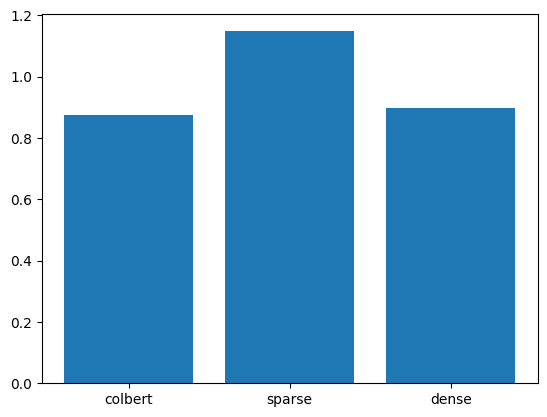

In [15]:
plt.bar(["colbert", "sparse", "dense"], [unique_df["colbert"].mean(), unique_df["sparse"].mean(), unique_df["dense"].mean()])
plt.show()

### Topic based

## Validation Set

In [16]:
df2 = dataframes["squad_structured_validation"]

In [17]:
df2.columns

Index(['squad_id', 'title', 'context', 'structurized_context', 'question',
       'answer_text', 'answer_start_index', 'structurized_answer_start_index',
       'similarity_metrics'],
      dtype='object')

In [18]:
df2 = df2.drop(columns=["structurized_context", "question", "answer_text", "answer_start_index", "structurized_answer_start_index"])

In [19]:
unique_df2 = df2.drop_duplicates(subset=['context'])
unique_df2 = unique_df2.reset_index(drop=True)
unique_df2

,squad_id,title,context,similarity_metrics
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,"{'colbert': [0.951384961605072], 'sparse': [2...."
1,56be4e1facb8001400a502f6,Super_Bowl_50,The Panthers finished the regular season with ...,"{'colbert': [0.8798649311065674], 'sparse': [1..."
2,56be4eafacb8001400a50302,Super_Bowl_50,The Broncos took an early lead in Super Bowl 5...,"{'colbert': [0.9056879281997681], 'sparse': [0..."
3,56be5333acb8001400a5030a,Super_Bowl_50,"CBS broadcast Super Bowl 50 in the U.S., and c...","{'colbert': [0.924893856048584], 'sparse': [1...."
4,56be53b8acb8001400a50314,Super_Bowl_50,"In early 2012, NFL Commissioner Roger Goodell ...","{'colbert': [0.9271186590194702], 'sparse': [0..."
...,...,...,...,...
2062,5737a5931c456719005744e7,Force,"where is the mass of the object, is the velo...","{'colbert': [0.8674808740615845], 'sparse': [1..."
2063,5737a7351c456719005744f1,Force,A conservative force that acts on a closed sys...,"{'colbert': [0.8601164221763611], 'sparse': [0..."
2064,5737a84dc3c5551400e51f59,Force,"For certain physical scenarios, it is impossib...","{'colbert': [0.865747332572937], 'sparse': [0...."
2065,5737a9afc3c5551400e51f61,Force,The connection between macroscopic nonconserva...,"{'colbert': [0.8727314472198486], 'sparse': [0..."


In [20]:
similarity_metrics_df2 = unique_df2["similarity_metrics"].apply(safe_json_loads).apply(pd.Series)
unique_df2 = pd.concat([unique_df2, similarity_metrics_df2], axis=1)

In [21]:
# If any of the similarity_metrics columns are lists, extract the first element
for col in similarity_metrics_df2.columns:
    if similarity_metrics_df2[col].apply(lambda x: isinstance(x, list)).any():
        similarity_metrics_df2[col] = similarity_metrics_df2[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Update unique_df with the processed columns
unique_df2 = pd.concat([unique_df2.drop(columns=similarity_metrics_df2.columns, errors='ignore'), similarity_metrics_df2], axis=1)
unique_df2

,squad_id,title,context,similarity_metrics,colbert,sparse,dense,sparse+dense,colbert+sparse+dense
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,"{'colbert': [0.951384961605072], 'sparse': [2....",0.951385,2.607422,0.970215,1.788818,1.509674
1,56be4e1facb8001400a502f6,Super_Bowl_50,The Panthers finished the regular season with ...,"{'colbert': [0.8798649311065674], 'sparse': [1...",0.879865,1.531250,0.913086,1.222168,1.108067
2,56be4eafacb8001400a50302,Super_Bowl_50,The Broncos took an early lead in Super Bowl 5...,"{'colbert': [0.9056879281997681], 'sparse': [0...",0.905688,0.998047,0.934082,0.966064,0.945939
3,56be5333acb8001400a5030a,Super_Bowl_50,"CBS broadcast Super Bowl 50 in the U.S., and c...","{'colbert': [0.924893856048584], 'sparse': [1....",0.924894,1.196289,0.943848,1.070068,1.021677
4,56be53b8acb8001400a50314,Super_Bowl_50,"In early 2012, NFL Commissioner Roger Goodell ...","{'colbert': [0.9271186590194702], 'sparse': [0...",0.927119,0.705078,0.938477,0.821777,0.856891
...,...,...,...,...,...,...,...,...,...
2062,5737a5931c456719005744e7,Force,"where is the mass of the object, is the velo...","{'colbert': [0.8674808740615845], 'sparse': [1...",0.867481,1.059570,0.882324,0.970947,0.936458
2063,5737a7351c456719005744f1,Force,A conservative force that acts on a closed sys...,"{'colbert': [0.8601164221763611], 'sparse': [0...",0.860116,0.782715,0.889648,0.836182,0.844160
2064,5737a84dc3c5551400e51f59,Force,"For certain physical scenarios, it is impossib...","{'colbert': [0.865747332572937], 'sparse': [0....",0.865747,0.727539,0.890137,0.808838,0.827808
2065,5737a9afc3c5551400e51f61,Force,The connection between macroscopic nonconserva...,"{'colbert': [0.8727314472198486], 'sparse': [0...",0.872731,0.739258,0.912109,0.825684,0.841366


In [22]:
print(unique_df2["colbert"].mean(), unique_df2["sparse"].mean(), unique_df2["dense"].mean())

0.885697421614652 1.2473139806709603 0.9067777311623125


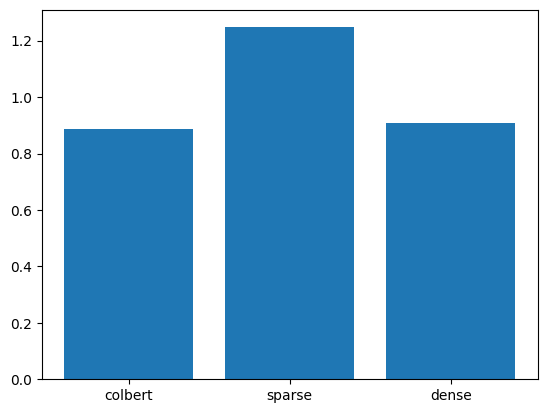

In [23]:
plt.bar(["colbert", "sparse", "dense"], [unique_df2["colbert"].mean(), unique_df2["sparse"].mean(), unique_df2["dense"].mean()])
plt.show()

### Topic based

## Combined

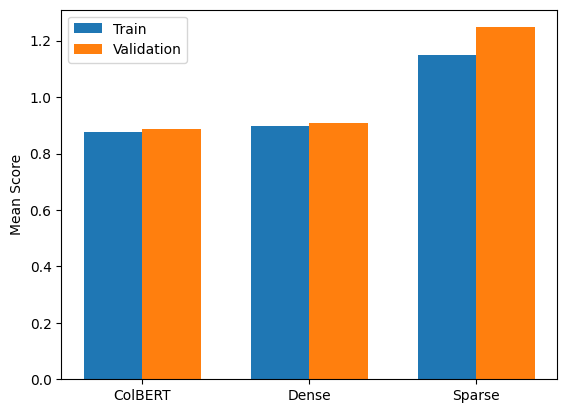

In [25]:
import numpy as np

metrics = ["ColBERT", "Dense", "Sparse"]
train_means = [unique_df[m.lower()].mean() for m in metrics]
val_means = [unique_df2[m.lower()].mean() for m in metrics]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_means, width, label='Train')
rects2 = ax.bar(x + width/2, val_means, width, label='Validation')

ax.set_ylabel('Mean Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.show()